### Analyse de the performance of the network when applying the LRPcomposite

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers, regularizers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pickle
import pathlib
import hashlib
import seaborn
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_resnet import *
from utils.utils_plot import *
from utils.DNN_models import *
from utils.rank_relevances import *

Num GPUs Available:  1


In [2]:
import yaml
conf = yaml.safe_load(open("config.yaml"))
PRECIP_XTRM = 0.95 # Percentile (threshold) for the extremes
PRECIP_DATA = 'ERA5-low' 

In [4]:
# load data
# test samples
dg_train_X = np.array(xr.open_dataarray('tmp/data/dg_train_X.nc'))
dg_train_Y_xtrm = xr.open_dataarray('tmp/data/dg_train_Y_xtrm0.95th.nc')

In [5]:
dg_test_X = np.array(xr.open_dataarray('tmp/data/dg_test_X.nc'))
dg_test_Y = np.array(xr.open_dataarray('tmp/data/dg_test_Y.nc'))
dg_test_Y_xtrm = xr.open_dataarray('tmp/data/dg_test_Y_xtrm0.95th.nc')

In [6]:
# coordinates
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')
# test-times
#times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2022-01-01'))
#times = pd.to_datetime(times)
# train-times
times = np.arange(np.datetime64('1979-01-01'), np.datetime64('2006-01-01'))
times = pd.to_datetime(times)

In [7]:
y_bool= dg_train_Y_xtrm

In [8]:
models = ['UNET1','UNET2','UNET3','UNET4']

In [9]:
# load weights
lrp_all = []
list_df = []
    
for m_id in models:
    print('LRP',m_id)
    lrp = np.load(f'tmp/LRP/lrpcomp_train_DNN_{m_id}.npy')
    lrp_all.append(lrp)
    localrel_avg, localrel_max  = getmap_localrel(lrp, conf['i_shape'], conf['varnames'], y_bool, lats_y, lons_x, times, icrop=3)
    rel_varmeans = localrel_avg.mean(axis=(0,1))
    df_sortedvars = [conf['varnames'][i] for i in np.argsort(rel_varmeans)[::-1]]
    df_sortval = [rel_varmeans[i] for i in np.argsort(rel_varmeans)[::-1]]
    data={'Model': m_id,'Variable' : df_sortedvars, 'Values' : df_sortval}
    df = pd.DataFrame(data)
    list_df.append(df)
    


LRP UNET1
LRP UNET2
LRP UNET3
LRP UNET4


In [10]:
df_all = pd.concat([list_df[1], list_df[3], list_df[2], list_df[0]])

In [11]:
dfpivot = df_all.pivot(columns='Model')

In [12]:
# plot the outputs

In [13]:
df_all.head()

,Model,Variable,Values
0,UNET2,RH700,0.133127
1,UNET2,U925,0.129633
2,UNET2,U1000,0.127742
3,UNET2,V1000,0.125127
4,UNET2,V925,0.123041


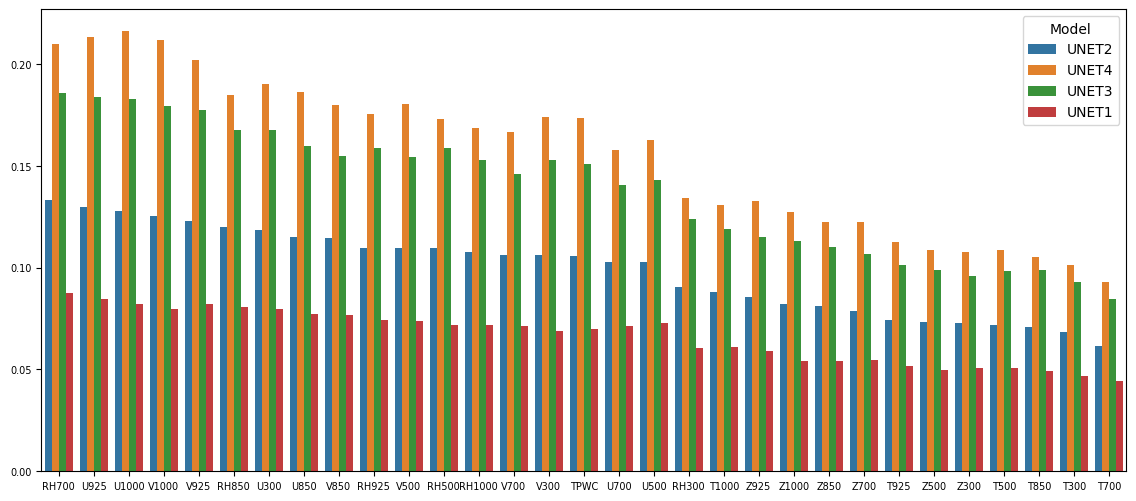

In [14]:
fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(ax=ax, x = "Variable", y = "Values", hue = "Model", data = df_all)
plt.tick_params(labelsize=7)
#plt.show()
ax.set_ylabel(None)
ax.set_xlabel(None)
# save figure 
fname = 'Ranking_predictors_test_UNETs'
plt.savefig('figures/' + fname + '.pdf')

In [15]:
# select UNET2 as the best network (higher scores)
rel = lrp_all[1]

In [16]:
pixelrel_avg, pixelrel_max = getmap_rel(rel, conf['i_shape'], y_bool, lons_x, lats_y, False)

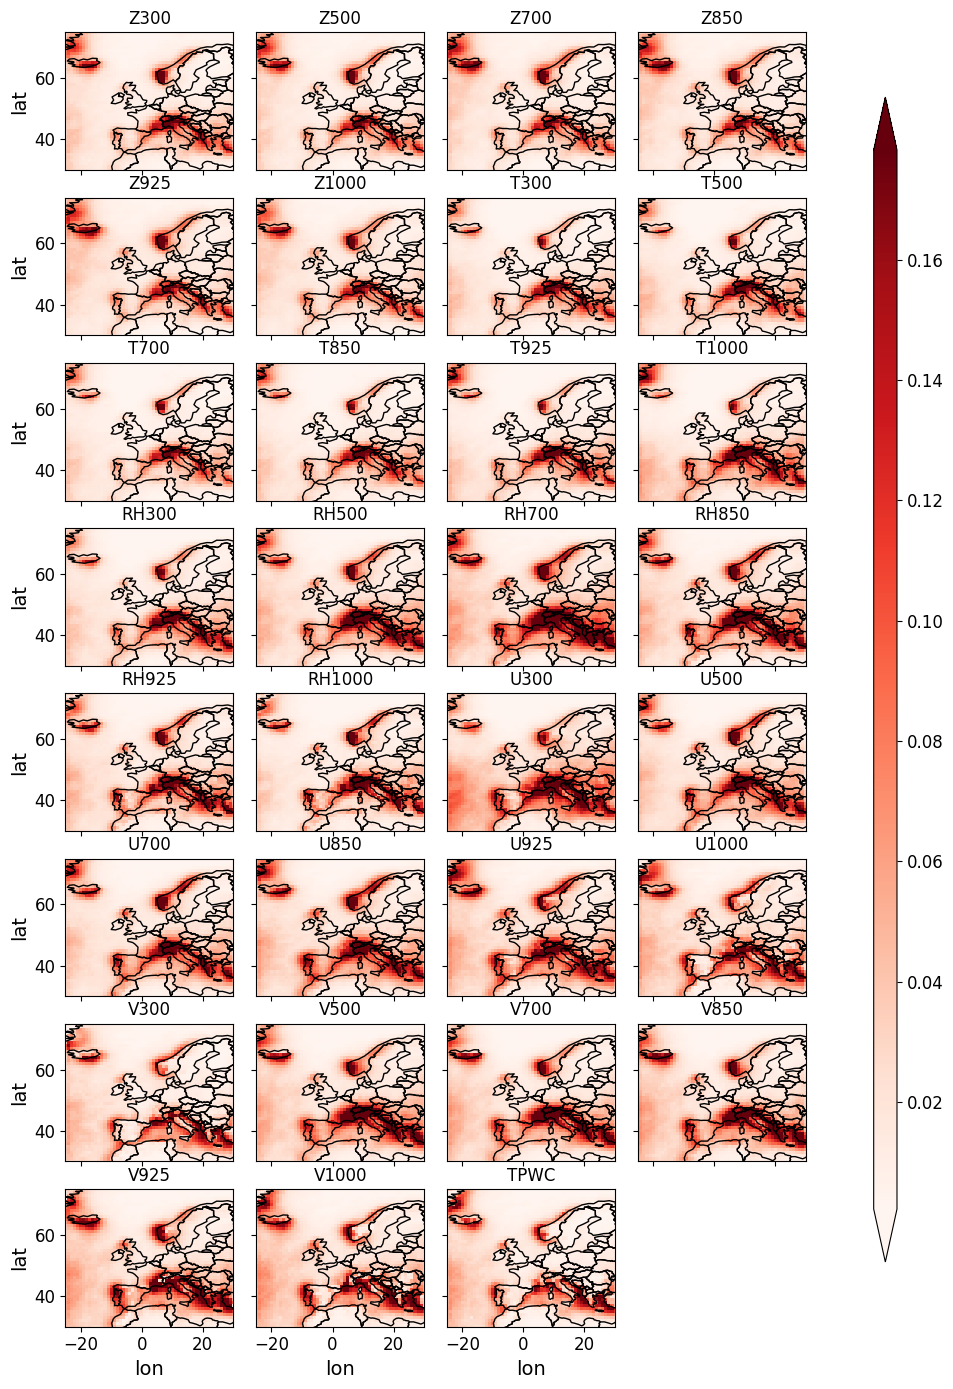

In [17]:
plot_xr_rel(pixelrel_avg, lats_y, lons_x, conf['varnames'], 'relevances_train_UNET2_pixelwise')

In [19]:
pixelrel_avg_u4, pixelrel_max_4 = getmap_rel(lrp_all[3], conf['i_shape'], y_bool, lons_x, lats_y, False)

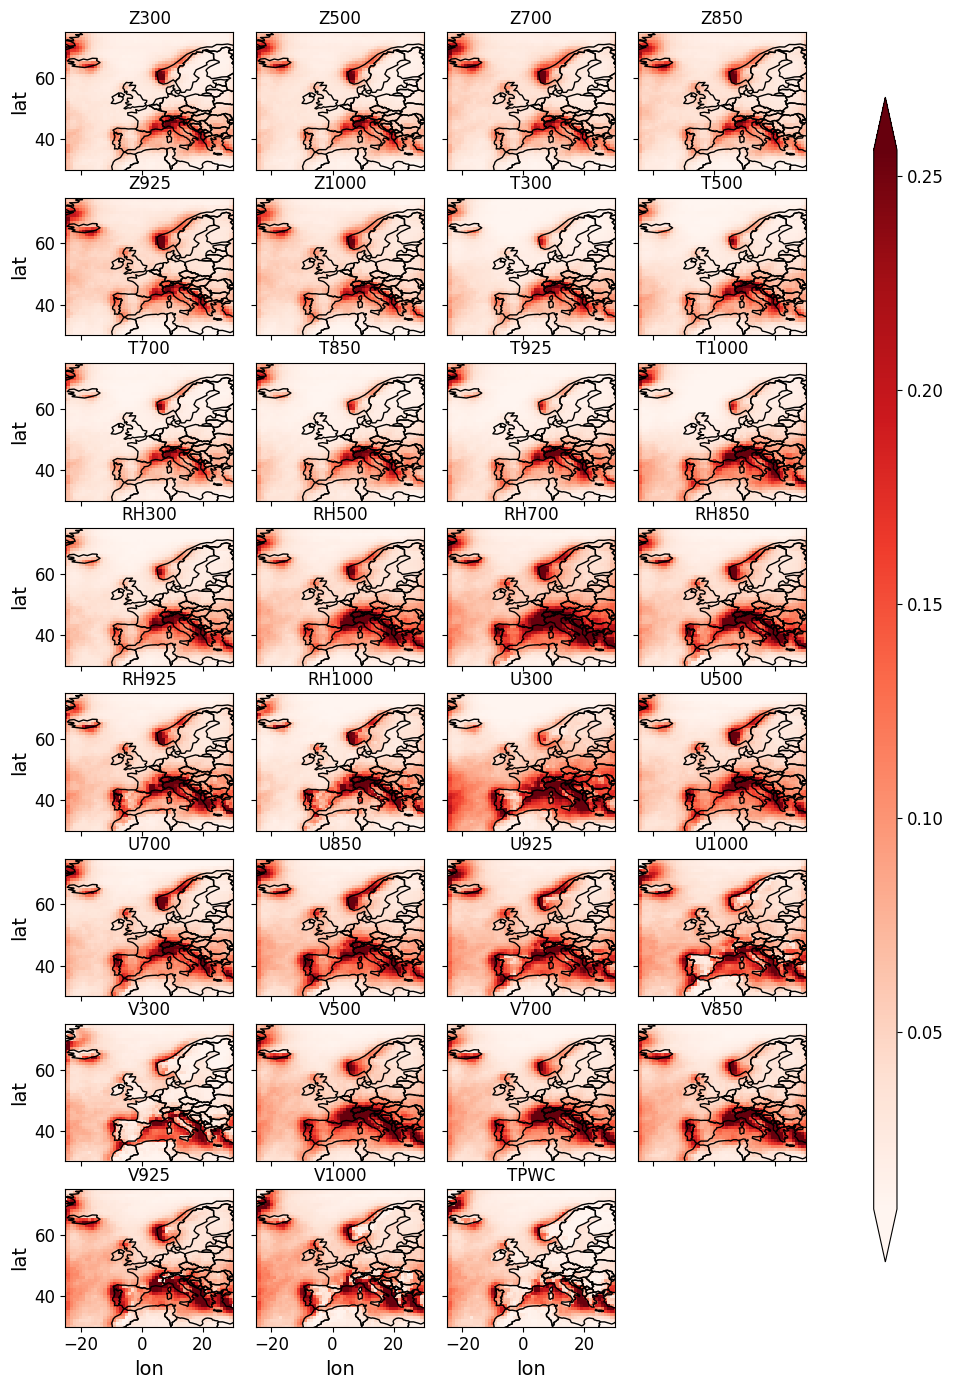

In [20]:
plot_xr_rel(pixelrel_avg_u4, lats_y, lons_x, conf['varnames'], 'relevances_train_UNET4_pixelwise')